## NPV - модель (страховой полис КАСКО)

Построим модель доходности для страхового полиса КАСКО. 

Клиент вносит страховую премию (tariff) в первый месяц, полис действует 12 месяцев, в течение года клиент может заявлять два типа убытков - "ущерб" или "тоталь, угон". 
При рассмотрении заявки для каждого клиента и застрахованного авто прогнозируется сумма убытков в следующие 12 месяцев (expected_loss, Hug_loss_distribution, mean_HGL_loss). При заявлении убытка "тоталь, угон" полис расторгается.

Построим модель на 3 года (36 месяцев), учитывая пролонгацию (продление) полиса.

Выгружаем смоделированные кривые из файла

In [1]:
import pandas as pd
import numpy as np

curves = pd.read_csv(
    "https://www.dropbox.com/s/z0y9u71e9mzhhwk/Insuranse_curves.csv?dl=1", 
    sep=";",  
    encoding='cp1251', 
    na_values = [''],
    index_col='Statement_num')
curves.head(40)

,ATR_rate,Hug_loss_rate
Statement_num,,
1,0.008,0.0020
2,0.007,0.0025
3,0.006,0.0035
4,0.005,0.0040
5,0.004,0.0025
6,0.003,0.0022
7,0.003,0.0022
8,0.003,0.0022
9,0.003,0.0022


ATR_rate - скорость перехода из портфеля активных клиентов в закрытый полис

Hug_loss_rate - вероятность крупного убытка (тоталь или угон автомобиля) в каждом месяце от кол-во активных клиентов в предыдущем месяце

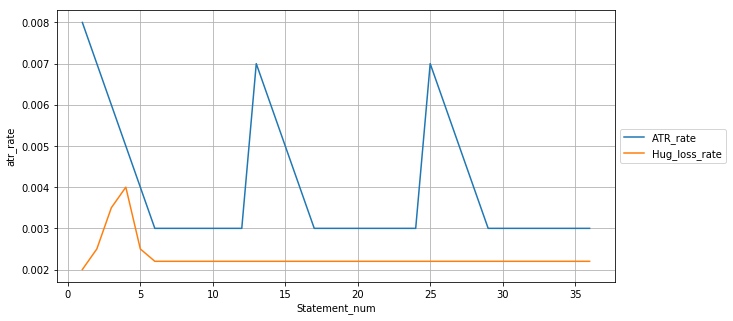

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt 

curves.plot( figsize=(10, 5), grid=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('atr_rate');

Функция .loc позволяет ссылаться на значение элемента в массиве:

In [3]:
curves.loc[[1, 5, 12, 27], ['ATR_rate']]

,ATR_rate
Statement_num,
1,0.008
5,0.004
12,0.003
27,0.005


С помощью кривых ATR_rate и Huge_Loss_rate прогнозируем распределение клиентов. 

Вводим два параметра prolongation_rate_1 и prolongation_rate_2 - доля продлений полиса на 2й и 3й год - доля клиентов из активного портфеля, которые подписывают полис на следующий год.

In [4]:
def distribution_accounts(prolongation_rate_1, prolongation_rate_2, manual_HGL_loss):
    curves_prolongation = curves.copy()
    
    ACT_account = pd.Series(name='ACT_account') #доля активных клиентов в каждом месяце
    ACT_account.loc[0] = 1
    ACT_account.index.name = 'Statement_num'
    ACT_account.sort_index(inplace=True)

    curves_prolongation.loc[13, 'ATR_rate'] = max(0, 1-prolongation_rate_1)   #учитываем пролонгацию на 2й год
    curves_prolongation.loc[25, 'ATR_rate'] = max(0, 1-prolongation_rate_2)   #учитываем пролонгацию на 3й год
    ATR_account = pd.Series(name='ATR_account')  #доля клиентов, расторгнувших договор
    ATR_account.loc[0] = 0
    ATR_account.index.name = 'Statement_num'

    HGL_account = pd.Series(name='HGL_account') #доля клиентов с убытком "тоталь, угон"
    HGL_account.loc[0] = 0
    HGL_account.index.name = 'Statement_num'

    for statement_num in range(1, 37):
   
        ATR_account.loc[statement_num] = (
            ATR_account.loc[statement_num - 1]
          + ACT_account.loc[statement_num - 1]* curves_prolongation.loc[statement_num, 'ATR_rate']   
        )

        HGL_account.loc[statement_num] = (
            HGL_account.loc[statement_num - 1]
          + ACT_account.loc[statement_num - 1]*curves.loc[statement_num, 'Hug_loss_rate']*manual_HGL_loss   
        )
        HGL_account.loc[statement_num]=min(1, HGL_account.loc[statement_num])

        ACT_account.loc[statement_num] = (1-ATR_account[statement_num] - HGL_account[statement_num])
        ACT_account.loc[statement_num]=max(0, ACT_account.loc[statement_num])
    
    return ACT_account, ATR_account, HGL_account

prolongation_rate_1=0.85
prolongation_rate_2=0.7
manual_HGL_loss=1
ACT_account, ATR_account, HGL_account = distribution_accounts(prolongation_rate_1, prolongation_rate_2, manual_HGL_loss)
pd.DataFrame([ATR_account, ACT_account, HGL_account]).style.format('{:.3f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
ATR_account,0.000,0.008,0.015,0.021,0.026,0.030,0.032,0.035,0.038,0.041,0.044,0.047,0.049,0.188,0.192,0.196,0.199,0.202,0.204,0.206,0.208,0.211,0.213,0.215,0.217,0.437,0.440,0.443,0.445,0.446,0.448,0.449,0.451,0.452,0.454,0.455,0.457
ACT_account,1.000,0.990,0.981,0.971,0.963,0.956,0.951,0.946,0.941,0.937,0.932,0.927,0.922,0.782,0.775,0.770,0.765,0.761,0.757,0.753,0.749,0.745,0.741,0.738,0.734,0.512,0.508,0.504,0.501,0.498,0.496,0.493,0.491,0.488,0.486,0.483,0.481
HGL_account,0.000,0.002,0.004,0.008,0.012,0.014,0.016,0.018,0.020,0.023,0.025,0.027,0.029,0.031,0.032,0.034,0.036,0.038,0.039,0.041,0.043,0.044,0.046,0.047,0.049,0.051,0.052,0.053,0.054,0.055,0.056,0.057,0.058,0.059,0.061,0.062,0.063


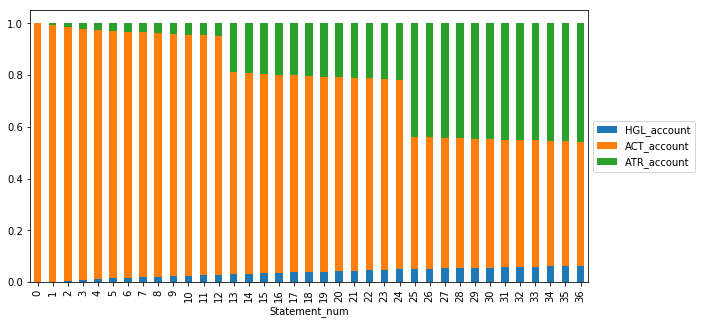

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt 

(pd.DataFrame([ACT_account, ATR_account, HGL_account])
   .T
   [['HGL_account', 'ACT_account', 'ATR_account']]
   .plot(kind='bar', stacked=True, figsize=(10, 5))
)

plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));

Большие скачки ATR_account в 13м и 25м месяце связаны с переоформлением полиса.

Tariff - страховая премия, которую выплачивает клиент за услуги страхования. 

Бухгалтерски страховая премия не сразу записывается в прибыль - каждый месяц добавляется 1/12 часть. При пролонгации полиса на 2й и 3й год страховая компания делает скидку клиенту (discount_prolongation_1, discount_prolongation_2).

In [6]:
def Accrued_tariff_calc(tariff, discount_prolongation_1, discount_prolongation_2, 
                        ACT_account, prolongation_rate_1, prolongation_rate_2):

    tariff_36 = pd.Series(name='tariff_36') #бухгалтерское начисление дохода от выплаченной премии
    tariff_36.loc[0] = tariff
    tariff_36.loc[1] = 0
    tariff_36.index.name = 'Statement_num'
    for statement_num in range(2, 37):
        tariff_36.loc[statement_num]=0
    tariff_36.loc[12] = tariff*(1-discount_prolongation_1)*ACT_account.loc[12]*prolongation_rate_1
    tariff_36.loc[24] = tariff*(1-discount_prolongation_2)*ACT_account.loc[24]*prolongation_rate_2
    
    Accrued_tariff = pd.Series(name='Accrued_tariff') #бухгалтерское начисление дохода от выплаченной премии
    Accrued_tariff.loc[0] = 0
    Accrued_tariff.index.name = 'Statement_num'

    for statement_num in range(1, 13):
        Accrued_tariff.loc[statement_num]=(
            tariff_36.loc[0]/12)   
    for statement_num in range(13, 25):
        Accrued_tariff.loc[statement_num]=(
            tariff_36.loc[12]/12 ) 
    for statement_num in range(25, 37):
        Accrued_tariff.loc[statement_num]=(
            tariff_36.loc[24]/12 )  

    return Accrued_tariff, tariff_36

tariff=40000
discount_prolongation_1=0.1
discount_prolongation_2=0.15
Accrued_tariff, tariff_36 =(Accrued_tariff_calc(tariff, discount_prolongation_1, discount_prolongation_2, 
                                                ACT_account, prolongation_rate_1, prolongation_rate_2)) 

pd.DataFrame([tariff_36, Accrued_tariff]).style.format('{:.0f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
tariff_36,40000,0,0,0,0,0,0,0,0,0,0,0,28214,0,0,0,0,0,0,0,0,0,0,0,17461,0,0,0,0,0,0,0,0,0,0,0,0
Accrued_tariff,0,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,2351,2351,2351,2351,2351,2351,2351,2351,2351,2351,2351,2351,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455


In [7]:
sum_tariff_1 = Accrued_tariff.loc[0:12].sum() 
sum_tariff_2 = Accrued_tariff.loc[13:24].sum()
sum_tariff_3 = Accrued_tariff.loc[25:36].sum()
sum_tariff_1 , sum_tariff_2, sum_tariff_3

(40000.00000000001, 28213.537512929048, 17461.339781528393)

In [8]:
def Loss_calc(expected_losses_12, mean_HGL_loss, decrease_losses_2y, decrease_losses_3y, HGL_account, ACT_account):
    Loss = pd.Series(name='Loss') 
    Loss.loc[0] = 0
    Loss.index.name = 'Statement_num'
    
    for statement_num in range(1, 13):
        Loss.loc[statement_num]=(((expected_losses_12/12)*ACT_account.loc[statement_num]) #убытки "ущерб"
        +(mean_HGL_loss*(HGL_account.loc[statement_num]-HGL_account.loc[statement_num-1])))  #убытки "тотать, угон"
    for statement_num in range(13, 25):
        Loss.loc[statement_num]=(((expected_losses_12/12)*(1-decrease_losses_2y)*ACT_account.loc[statement_num])
        +(mean_HGL_loss*(HGL_account.loc[statement_num]-HGL_account.loc[statement_num-1])))
    for statement_num in range(25, 37):
        Loss.loc[statement_num]=(((expected_losses_12/12)*(1-decrease_losses_3y)*ACT_account.loc[statement_num])
        +(mean_HGL_loss*(HGL_account.loc[statement_num]-HGL_account.loc[statement_num-1])))
    return Loss

Loss=Loss_calc(30000, 1000000, 0.2, 0.3, HGL_account, ACT_account)
pd.DataFrame([Loss]).style.format('{:.0f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
Loss,0,4475,4926,5860,6291,4797,4482,4459,4436,4413,4390,4367,4344,3592,3270,3245,3223,3205,3188,3171,3155,3139,3122,3106,3090,2510,2015,1999,1986,1974,1964,1954,1944,1934,1923,1913,1904


In [9]:
loss_1 = Loss.loc[0:12].sum()
loss_2 = Loss.loc[13:24].sum()
loss_3 = Loss.loc[25:36].sum()
loss_1 , loss_2, loss_3

(57239.68823483106, 38505.944412011835, 24019.705036220996)

 Денежные средства, не учтенные доходом от страховой премии, идут на создание резервов - Provisions.

In [10]:
def Provisions_calc(Accrued_tariff, tariff_36 ):
    Provisions = pd.Series(name='Provisions') 
    Provisions.loc[0] = tariff_36.loc[0]
    Provisions.index.name = 'Statement_num'
    for statement_num in range(1, 13):
        Provisions[statement_num]=max(0, tariff_36.loc[0]-Accrued_tariff.loc[1:statement_num].sum())+tariff_36.loc[statement_num]
    for statement_num in range(13, 25):
        Provisions[statement_num]=max(0, tariff_36.loc[12]-Accrued_tariff.loc[13:statement_num].sum())+tariff_36.loc[statement_num]              
    for statement_num in range(25, 37):
        Provisions[statement_num]=max(0, tariff_36.loc[24]-Accrued_tariff.loc[25:statement_num].sum())+tariff_36.loc[statement_num]               
    return Provisions
Provisions=Provisions_calc(Accrued_tariff, tariff_36)

pd.DataFrame([ tariff_36, Accrued_tariff, Provisions, Loss]).style.format('{:.0f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
tariff_36,40000,0,0,0,0,0,0,0,0,0,0,0,28214,0,0,0,0,0,0,0,0,0,0,0,17461,0,0,0,0,0,0,0,0,0,0,0,0
Accrued_tariff,0,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,3333,2351,2351,2351,2351,2351,2351,2351,2351,2351,2351,2351,2351,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455,1455
Provisions,40000,36667,33333,30000,26667,23333,20000,16667,13333,10000,6667,3333,28214,25862,23511,21160,18809,16458,14107,11756,9405,7053,4702,2351,17461,16006,14551,13096,11641,10186,8731,7276,5820,4365,2910,1455,0
Loss,0,4475,4926,5860,6291,4797,4482,4459,4436,4413,4390,4367,4344,3592,3270,3245,3223,3205,3188,3171,3155,3139,3122,3106,3090,2510,2015,1999,1986,1974,1964,1954,1944,1934,1923,1913,1904


По требованиям регулятора для выдачи страхового полиса необходимо выделение собственных средств из капитала акционера (Capital). 

Полученная страховая премия и деньги из капитала не просто "замораживаются", а отправляются на депозиты в других банках(вкладываются в покупки облигаций, ценных бумаг) для получения дополнительного инвестиционного дохода (Income_Investment). 

In [11]:
capital_requirement=0.2
income_investment_rate=0.08

def Capital_calc(capital_requirement, tariff_36):
    Capital = pd.Series(name='Capital')
    Capital.loc[0] = tariff_36.loc[0]*capital_requirement
    Capital.index.name = 'Statement_num'
          
    for statement_num in range(1, 13):
        Capital[statement_num]=(tariff_36.loc[0:(statement_num-1)].sum()*capital_requirement)
    for statement_num in range(13, 25):
        Capital[statement_num]=(tariff_36.loc[12:(statement_num-1)].sum()*capital_requirement)              
    for statement_num in range(25, 37):
        Capital[statement_num]=(tariff_36.loc[24:(statement_num-1)].sum()*capital_requirement)  
    return Capital
       
Capital=Capital_calc(capital_requirement, tariff_36)    

def Investment_calc(Capital, Provisions):
    Investment = pd.Series(name='Investment')
    Investment.loc[0] = Capital.loc[0]+Provisions.loc[0]
    Investment.index.name = 'Statement_num'  
    
    for statement_num in range(1, 37):
        Investment[statement_num]=Capital.loc[statement_num]+Provisions.loc[statement_num]
    return Investment

Investment=Investment_calc(Capital, Provisions)
        
def Income_Investment_calc(income_investment_rate, Investment):
    Income_Investment = pd.Series(name='Income_Investment')
    Income_Investment.loc[0] = 0
    Income_Investment.index.name = 'Statement_num'  
    
    for statement_num in range(1, 37):
        Income_Investment[statement_num]=Investment.loc[statement_num]*(income_investment_rate/12)
    return Income_Investment
       
Income_Investment=Income_Investment_calc(income_investment_rate, Investment)    
pd.DataFrame([tariff_36, Capital, Provisions, Investment, Income_Investment]).style.format('{:.0f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
tariff_36,40000,0,0,0,0,0,0,0,0,0,0,0,28214,0,0,0,0,0,0,0,0,0,0,0,17461,0,0,0,0,0,0,0,0,0,0,0,0
Capital,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,8000,5643,5643,5643,5643,5643,5643,5643,5643,5643,5643,5643,5643,3492,3492,3492,3492,3492,3492,3492,3492,3492,3492,3492,3492
Provisions,40000,36667,33333,30000,26667,23333,20000,16667,13333,10000,6667,3333,28214,25862,23511,21160,18809,16458,14107,11756,9405,7053,4702,2351,17461,16006,14551,13096,11641,10186,8731,7276,5820,4365,2910,1455,0
Investment,48000,44667,41333,38000,34667,31333,28000,24667,21333,18000,14667,11333,36214,31505,29154,26803,24452,22101,19749,17398,15047,12696,10345,7994,23104,19498,18043,16588,15133,13678,12223,10768,9313,7858,6402,4947,3492
Income_Investment,0,298,276,253,231,209,187,164,142,120,98,76,241,210,194,179,163,147,132,116,100,85,69,53,154,130,120,111,101,91,81,72,62,52,43,33,23


Суммируем все рассчитанные доходы(страховая премия, инвестиционный доход) и расходы(страховые потери, расходы на обслуживание клиентов и урегулирование убытков):

In [12]:
def Revenue_calc(Accrued_tariff, Income_Investment):
    Revenue = pd.Series(name='Revenue')
    Revenue.loc[0] = 0
    Revenue.index.name = 'Statement_num'    
    for statement_num in range(1, 37):
        Revenue[statement_num]=(
            Accrued_tariff.loc[statement_num]  #страховая премия по начислениям 
            +Income_Investment.loc[statement_num])  #инвестиционный доход
    return Revenue

def Expenses_calc(Loss, loss_adjustment, opex, ACT_account):
    Expenses = pd.Series(name='Expenses')
    Expenses.loc[0] = 0
    Expenses.index.name = 'Statement_num'    
    for statement_num in range(1, 37):
        Expenses[statement_num]=(
            Loss.loc[statement_num]   #страховые убытки
            +Loss.loc[statement_num]*loss_adjustment   #расходы на урегулирование убытков
            +ACT_account.loc[statement_num]*opex)  #расходы на обслуживание клиентов
    return Expenses

opex=150
loss_adjustment=0.05
Expenses=Expenses_calc(Loss, loss_adjustment, opex, ACT_account)
Revenue=Revenue_calc(Accrued_tariff, Income_Investment)
pd.DataFrame([Revenue, Expenses]).style.format('{:.0f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
Revenue,0,3631,3609,3587,3564,3542,3520,3498,3476,3453,3431,3409,3575,2561,2545,2530,2514,2498,2483,2467,2451,2436,2420,2404,2505,1585,1575,1566,1556,1546,1537,1527,1517,1507,1498,1488,1478
Expenses,0,4847,5320,6299,6750,5180,4849,4824,4799,4774,4749,4724,4700,3889,3550,3523,3499,3479,3461,3443,3425,3407,3390,3372,3354,2712,2192,2175,2160,2148,2137,2125,2114,2103,2093,2082,2071


Рассчитаем чистый доход после уплаты налогов (Net income after tax):

In [13]:
def Net_Income_After_Tax_calc(Revenue, Expenses, tax_rate):
    Net_Income_After_Tax = pd.Series(name='Net_Income_After_Tax')
    Net_Income_After_Tax.loc[0] = 0
    Net_Income_After_Tax.index.name = 'Statement_num'    
    for statement_num in range(1, 37):
        Net_Income_After_Tax[statement_num]=(
            (Revenue.loc[statement_num]-Expenses.loc[statement_num])
            -max(0, (Revenue.loc[statement_num]-Expenses.loc[statement_num]))*tax_rate)
    return Net_Income_After_Tax

tax_rate=0.2
Net_Income_After_Tax=Net_Income_After_Tax_calc(Revenue, Expenses, tax_rate)
pd.DataFrame([Revenue, Expenses, Net_Income_After_Tax]).style.format('{:.0f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36
Revenue,0,3631,3609,3587,3564,3542,3520,3498,3476,3453,3431,3409,3575,2561,2545,2530,2514,2498,2483,2467,2451,2436,2420,2404,2505,1585,1575,1566,1556,1546,1537,1527,1517,1507,1498,1488,1478
Expenses,0,4847,5320,6299,6750,5180,4849,4824,4799,4774,4749,4724,4700,3889,3550,3523,3499,3479,3461,3443,3425,3407,3390,3372,3354,2712,2192,2175,2160,2148,2137,2125,2114,2103,2093,2082,2071
Net_Income_After_Tax,0,-1216,-1711,-2712,-3186,-1638,-1329,-1326,-1323,-1320,-1318,-1315,-1125,-1327,-1005,-993,-985,-981,-978,-976,-974,-972,-969,-968,-849,-1127,-616,-609,-604,-601,-600,-599,-597,-596,-595,-594,-592


### Распределим все денежные потоки:

1) Между страховой компанией и клиентами (CF_to_customers)

2) От страховой компании - все расходы и налоги (CF_Costs_Tax)

3) Между страховой компанией и партнерами (CF_to_Partners)

4) Между страховой компанией и акционерами (CF_to_Shareholders):

In [14]:
def CashFlows_calc(tariff_36, Loss, opex, loss_adjustment, ACT_account, tax_rate, Investment, Income_Investment,
                  Net_Income_After_Tax, Capital):
    CF_to_Customers = pd.Series(name='CF_to_Customers')
    CF_to_Customers.loc[0] = -tariff_36.loc[0]
    CF_to_Customers.index.name = 'Statement_num'
    for statement_num in range(1, 37):
        CF_to_Customers[statement_num]=(
            -tariff_36.loc[statement_num]    #оплата страховой премии
            +Loss.loc[statement_num]       )  #выплата по страховым случаям
    CF_to_Customers.loc[37] = 0
        
    CF_Costs_Tax = pd.Series(name='CF_Costs_Tax')
    CF_Costs_Tax.loc[0] = 0
    CF_Costs_Tax.index.name = 'Statement_num'
    for statement_num in range(1, 37):
        CF_Costs_Tax[statement_num]=(
            Loss.loc[statement_num]*loss_adjustment
            +ACT_account.loc[statement_num]*opex
            +max(0, (Revenue.loc[statement_num]-Expenses.loc[statement_num]))*tax_rate)
    CF_Costs_Tax.loc[37] = 0
    
    CF_to_Partners = pd.Series(name='CF_to_Partners')
    CF_to_Partners.loc[0] = Investment.loc[0]
    CF_to_Partners.index.name = 'Statement_num'
    for statement_num in range(1, 37):
        CF_to_Partners[statement_num]=(
            (Investment.loc[statement_num]-Investment.loc[statement_num-1])
            -Income_Investment.loc[statement_num])
    CF_to_Partners.loc[37] = - Investment.loc[36]
    
    CF_to_Shareholders = pd.Series(name='CF_to_Shareholders')
    CF_to_Shareholders.loc[0] = -Capital.loc[0]
    CF_to_Shareholders.index.name = 'Statement_num'
    for statement_num in range(1, 37):
        CF_to_Shareholders.loc[statement_num]=(
            Net_Income_After_Tax.loc[statement_num]
            -Capital.loc[statement_num]+Capital.loc[statement_num-1])
    CF_to_Shareholders.loc[37] = Investment.loc[36]
    
    return CF_to_Customers, CF_Costs_Tax, CF_to_Partners, CF_to_Shareholders

CF_to_Customers, CF_Costs_Tax, CF_to_Partners, CF_to_Shareholders=(
    CashFlows_calc(tariff_36, Loss, opex, loss_adjustment, ACT_account, tax_rate, Investment, Income_Investment,
                  Net_Income_After_Tax, Capital))

Null = pd.Series(name='Null')
Null.loc[0] = CF_to_Customers.loc[0] + CF_Costs_Tax.loc[0] + CF_to_Partners.loc[0] + CF_to_Shareholders.loc[0]
Null.index.name = 'Statement_num'
for statement_num in range (0, 38):
    Null[statement_num]=(
    CF_to_Customers.loc[statement_num] 
    + CF_Costs_Tax.loc[statement_num] 
    + CF_to_Partners.loc[statement_num] 
    + CF_to_Shareholders.loc[statement_num])
pd.DataFrame([CF_to_Customers, CF_Costs_Tax, CF_to_Partners, CF_to_Shareholders, Null]).style.format('{:.0f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
CF_to_Customers,-40000,4475,4926,5860,6291,4797,4482,4459,4436,4413,4390,4367,-23869,3592,3270,3245,3223,3205,3188,3171,3155,3139,3122,3106,-14371,2510,2015,1999,1986,1974,1964,1954,1944,1934,1923,1913,1904,0
CF_Costs_Tax,0,372,393,439,459,383,367,365,363,361,359,357,356,297,280,278,276,274,273,272,270,269,267,266,265,202,177,176,174,173,173,172,171,170,169,168,167,0
CF_to_Partners,48000,-3631,-3609,-3587,-3564,-3542,-3520,-3498,-3476,-3453,-3431,-3409,24639,-4918,-2545,-2530,-2514,-2498,-2483,-2467,-2451,-2436,-2420,-2404,14956,-3736,-1575,-1566,-1556,-1546,-1537,-1527,-1517,-1507,-1498,-1488,-1478,-3492
CF_to_Shareholders,-8000,-1216,-1711,-2712,-3186,-1638,-1329,-1326,-1323,-1320,-1318,-1315,-1125,1030,-1005,-993,-985,-981,-978,-976,-974,-972,-969,-968,-849,1023,-616,-609,-604,-601,-600,-599,-597,-596,-595,-594,-592,3492
Null,0,-0,0,-0,-0,0,0,0,-0,0,-0,-0,0,0,-0,-0,0,0,-0,-0,0,0,0,0,0,-0,0,-0,0,-0,0,0,0,0,0,0,-0,0


Итоговый денежный поток продисконтируем - ставка discount_rate:

In [15]:
def cumulative_discount_CF_to_Shareholders_calc(discount_rate, CF_to_Shareholders):
    cum_disc_CF_to_Shareholders= pd.Series(name='cum_disc_CF_to_Shareholders')
    cum_disc_CF_to_Shareholders.loc[0] = CF_to_Shareholders.loc[0]
    cum_disc_CF_to_Shareholders.index.name = 'Statement_num'
    
    for statement_num in range(1, 38):
        cum_disc_CF_to_Shareholders.loc[statement_num]=(
            cum_disc_CF_to_Shareholders.loc[statement_num-1]
            +(1+discount_rate)**(-statement_num/12)*CF_to_Shareholders.loc[statement_num]
        )
    return cum_disc_CF_to_Shareholders

discount_rate=0.15
cum_disc_CF_to_Shareholders=cumulative_discount_CF_to_Shareholders_calc(discount_rate, CF_to_Shareholders)
pd.DataFrame([CF_to_Shareholders, cum_disc_CF_to_Shareholders]).style.format('{:.0f}')

Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
CF_to_Shareholders,-8000,-1216,-1711,-2712,-3186,-1638,-1329,-1326,-1323,-1320,-1318,-1315,-1125,1030,-1005,-993,-985,-981,-978,-976,-974,-972,-969,-968,-849,1023,-616,-609,-604,-601,-600,-599,-597,-596,-595,-594,-592,3492
cum_disc_CF_to_Shareholders,-8000,-9202,-10874,-13493,-16534,-18079,-19318,-20541,-21746,-22935,-24108,-25265,-26243,-25358,-26211,-27045,-27862,-28667,-29460,-30242,-31013,-31774,-32524,-33265,-33907,-33142,-33597,-34042,-34478,-34907,-35330,-35747,-36159,-36565,-36965,-37360,-37749,-35480


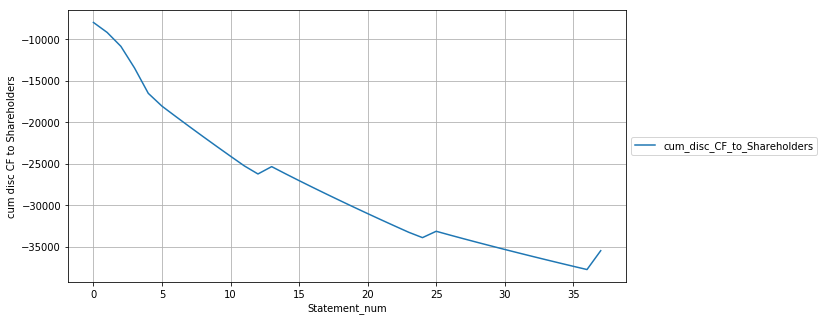

In [16]:
%matplotlib inline
import matplotlib.pyplot as plt 

cum_disc_CF_to_Shareholders.plot(figsize=(10, 5), grid=True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.ylabel('cum disc CF to Shareholders');

In [17]:
def NPV_calc(prolongation_rate_1, prolongation_rate_2, manual_HGL_loss,
        tariff, discount_prolongation_1, discount_prolongation_2,
        expected_losses_12, mean_HGL_loss, 
        decrease_losses_2y, decrease_losses_3y, 
        capital_requirement, 
        income_investment_rate,
        loss_adjustment, opex, 
        tax_rate, 
        discount_rate,
        Acquisition_cost):
    
    ACT_account, ATR_account, HGL_account = distribution_accounts(prolongation_rate_1, prolongation_rate_2, \
                                                                  manual_HGL_loss)
    Accrued_tariff, tariff_36 = Accrued_tariff_calc(tariff, discount_prolongation_1, discount_prolongation_2, 
                                                    ACT_account, prolongation_rate_1, prolongation_rate_2) 
    Loss=Loss_calc(expected_losses_12, mean_HGL_loss, decrease_losses_2y, decrease_losses_3y, \
                   HGL_account, ACT_account)
    Provisions=Provisions_calc(Accrued_tariff, tariff_36) 
    Capital=Capital_calc(capital_requirement, tariff_36)
    Investment=Investment_calc(Capital, Provisions)
    Income_Investment=Income_Investment_calc(income_investment_rate, Investment)
    Revenue=Revenue_calc(Accrued_tariff, Income_Investment)
    Expenses=Expenses_calc(Loss, loss_adjustment, opex, ACT_account)
    Net_Income_After_Tax=Net_Income_After_Tax_calc(Revenue, Expenses, tax_rate)
    CF_to_Customers, CF_Costs_Tax, CF_to_Partners, CF_to_Shareholders=CashFlows_calc(tariff_36, Loss, opex, 
                      loss_adjustment, ACT_account, tax_rate, Investment, Income_Investment, Net_Income_After_Tax, Capital)
    cum_disc_CF_to_Shareholders=cumulative_discount_CF_to_Shareholders_calc(discount_rate, CF_to_Shareholders)
    PV=cum_disc_CF_to_Shareholders.loc[37]
    NPV=PV-Acquisition_cost
    
    return PV, NPV, ACT_account, Accrued_tariff, tariff_36, Loss, Provisions, Capital, Investment, \
           Income_Investment, Revenue, Expenses, Net_Income_After_Tax, \
           CF_to_Customers, CF_Costs_Tax, CF_to_Partners, CF_to_Shareholders, cum_disc_CF_to_Shareholders
     
PV, NPV, ACT_account, Accrued_tariff, tariff_36, Loss, Provisions, Capital, Investment, \
Income_Investment, Revenue, Expenses, Net_Income_After_Tax,  \
CF_to_Customers, CF_Costs_Tax, CF_to_Partners, CF_to_Shareholders, cum_disc_CF_to_Shareholders=NPV_calc(
            prolongation_rate_1=0.75, prolongation_rate_2=0.6, manual_HGL_loss=1,
            tariff=60000, discount_prolongation_1=0.9, discount_prolongation_2=0.9,
            expected_losses_12=15000, mean_HGL_loss=1000000, 
            decrease_losses_2y=0.3, decrease_losses_3y=0.3, 
            capital_requirement=0.2, 
            income_investment_rate=0.1,
            loss_adjustment=0.05, opex=100, 
            tax_rate=0.2, 
            discount_rate=0.1,
            Acquisition_cost=10000
           )

print(f'PV {PV:.0f}, NPV {NPV:.0f}')
pd.DataFrame([ACT_account, tariff_36, Accrued_tariff, Loss, 
              Provisions, Capital, Investment, Income_Investment, 
              Revenue, Expenses, Net_Income_After_Tax,  CF_to_Customers, CF_Costs_Tax, 
              CF_to_Partners, CF_to_Shareholders, cum_disc_CF_to_Shareholders]).style.format('{:.2f}')

PV -17918, NPV -27918


Statement_num,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37
ACT_account,1.00,0.99,0.98,0.97,0.96,0.96,0.95,0.95,0.94,0.94,0.93,0.93,0.92,0.69,0.68,0.68,0.67,0.67,0.67,0.66,0.66,0.66,0.65,0.65,0.65,0.39,0.38,0.38,0.38,0.38,0.37,0.37,0.37,0.37,0.37,0.36,0.36,nan
tariff_36,60000.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,4149.05,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,2329.67,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,nan
Accrued_tariff,0.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,5000.00,345.75,345.75,345.75,345.75,345.75,345.75,345.75,345.75,345.75,345.75,345.75,345.75,194.14,194.14,194.14,194.14,194.14,194.14,194.14,194.14,194.14,194.14,194.14,194.14,nan
Loss,0.00,3237.50,3700.74,4646.18,5088.29,3601.70,3292.95,3275.83,3258.80,3241.85,3224.99,3208.22,3191.54,2631.72,2115.20,2098.46,2083.94,2071.61,2060.84,2050.12,2039.46,2028.86,2018.31,2007.81,1997.37,1762.19,1186.80,1177.41,1169.26,1162.35,1156.30,1150.29,1144.31,1138.36,1132.44,1126.55,1120.69,nan
Provisions,60000.00,55000.00,50000.00,45000.00,40000.00,35000.00,30000.00,25000.00,20000.00,15000.00,10000.00,5000.00,4149.05,3803.30,3457.54,3111.79,2766.03,2420.28,2074.52,1728.77,1383.02,1037.26,691.51,345.75,2329.67,2135.53,1941.40,1747.26,1553.12,1358.98,1164.84,970.70,776.56,582.42,388.28,194.14,0.00,nan
Capital,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,12000.00,829.81,829.81,829.81,829.81,829.81,829.81,829.81,829.81,829.81,829.81,829.81,829.81,465.93,465.93,465.93,465.93,465.93,465.93,465.93,465.93,465.93,465.93,465.93,465.93,nan
Investment,72000.00,67000.00,62000.00,57000.00,52000.00,47000.00,42000.00,37000.00,32000.00,27000.00,22000.00,17000.00,16149.05,4633.11,4287.35,3941.60,3595.84,3250.09,2904.33,2558.58,2212.83,1867.07,1521.32,1175.56,3159.48,2601.47,2407.33,2213.19,2019.05,1824.91,1630.77,1436.63,1242.49,1048.35,854.21,660.07,465.93,nan
Income_Investment,0.00,558.33,516.67,475.00,433.33,391.67,350.00,308.33,266.67,225.00,183.33,141.67,134.58,38.61,35.73,32.85,29.97,27.08,24.20,21.32,18.44,15.56,12.68,9.80,26.33,21.68,20.06,18.44,16.83,15.21,13.59,11.97,10.35,8.74,7.12,5.50,3.88,nan
Revenue,0.00,5558.33,5516.67,5475.00,5433.33,5391.67,5350.00,5308.33,5266.67,5225.00,5183.33,5141.67,5134.58,384.36,381.48,378.60,375.72,372.84,369.96,367.08,364.19,361.31,358.43,355.55,372.08,215.82,214.20,212.58,210.96,209.35,207.73,206.11,204.49,202.88,201.26,199.64,198.02,nan
Expenses,0.00,3498.38,3983.84,4975.62,5438.96,3877.41,3552.73,3534.26,3515.88,3497.60,3479.41,3461.32,3443.32,2832.25,2289.35,2271.27,2255.61,2242.31,2230.65,2219.05,2207.51,2196.03,2184.61,2173.25,2161.95,1888.98,1284.51,1274.37,1265.58,1258.12,1251.58,1245.07,1238.60,1232.16,1225.75,1219.38,1213.04,nan


In [18]:
def NPV_short(prolongation_rate_1, prolongation_rate_2, manual_HGL_loss, tariff, 
              discount_prolongation_1, discount_prolongation_2, expected_losses_12, mean_HGL_loss, 
              decrease_losses_2y, decrease_losses_3y, capital_requirement, 
              income_investment_rate, loss_adjustment, opex, tax_rate, discount_rate, Acquisition_cost):
    
    ACT_account, ATR_account, HGL_account = distribution_accounts(prolongation_rate_1, prolongation_rate_2, \
                                                                  manual_HGL_loss)
    Accrued_tariff, tariff_36 = Accrued_tariff_calc(tariff, discount_prolongation_1, discount_prolongation_2, 
                                                    ACT_account, prolongation_rate_1, prolongation_rate_2) 
    Loss=Loss_calc(expected_losses_12, mean_HGL_loss, decrease_losses_2y, decrease_losses_3y, \
                   HGL_account, ACT_account)
    Provisions=Provisions_calc(Accrued_tariff, tariff_36) 
    Capital=Capital_calc(capital_requirement, tariff_36)
    Investment=Investment_calc(Capital, Provisions)
    Income_Investment=Income_Investment_calc(income_investment_rate, Investment)
    Revenue=Revenue_calc(Accrued_tariff, Income_Investment)
    Expenses=Expenses_calc(Loss, loss_adjustment, opex, ACT_account)
    Net_Income_After_Tax=Net_Income_After_Tax_calc(Revenue, Expenses, tax_rate)
    CF_to_Customers, CF_Costs_Tax, CF_to_Partners, CF_to_Shareholders=CashFlows_calc(tariff_36, Loss, opex, 
                      loss_adjustment, ACT_account, tax_rate, Investment, \
                      Income_Investment, Net_Income_After_Tax, Capital)
    cum_disc_CF_to_Shareholders=cumulative_discount_CF_to_Shareholders_calc(discount_rate, CF_to_Shareholders)
    PV=cum_disc_CF_to_Shareholders.loc[37]
    NPV=PV-Acquisition_cost
    
    return PV, NPV
     
PV, NPV=NPV_short(prolongation_rate_1=0.75, 
                  prolongation_rate_2=0.6, 
                  manual_HGL_loss=1,
                  tariff=60000, 
                  discount_prolongation_1=0.9, 
                  discount_prolongation_2=0.9, 
                  expected_losses_12=15000, 
                  mean_HGL_loss=1000000, 
                  decrease_losses_2y=0.3, 
                  decrease_losses_3y=0.3, 
                  capital_requirement=0.2, 
                  income_investment_rate=0.1, 
                  loss_adjustment=0.05, 
                  opex=100, 
                  tax_rate=0.2, 
                  discount_rate=0.1, 
                  Acquisition_cost=10000
           )
PV, NPV

(-17917.721840514972, -27917.721840514972)

## Применение NPV-модели и стресс-тестирование.

### Настроим уровень одобрения для разных каналов привлечения. 

Рассмотрим два канала привлечения с разными стоимостями привлечения и разными уровнями пролонгации на 2 и 3 год.
Посчитаем NPV при разных Expected Losses на первый год (expected_losses_12).

In [19]:
expected_losses = pd.Series(5000* np.arange(1,16),index = np.arange(1,16),name='expected_losses')
expected_losses.index.name = 'num'

NPV_channel_1=pd.Series(name='NPV_channel_1')
NPV_channel_1.index.name = 'num'

Acquisition_cost=10000
prolongation_rate_1=0.9
prolongation_rate_2=0.85
for num in range(1, 16):
        PV, NPV = NPV_short(prolongation_rate_1=prolongation_rate_1, 
                     prolongation_rate_2=prolongation_rate_2, 
                     manual_HGL_loss=0.5,
                     tariff=90000, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=(expected_losses.loc[num]), 
                     mean_HGL_loss=300000, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=100, 
                     tax_rate=0.2, 
                     discount_rate=0.15,
                     Acquisition_cost=Acquisition_cost
                    )
        NPV_channel_1.loc[num]=NPV
            
NPV_channel_2=pd.Series(name='NPV_channel_2')
NPV_channel_2.index.name = 'num'

Acquisition_cost=5000
prolongation_rate_1=0.5
prolongation_rate_2=0.3
for num in range(1, 16):
            PV, NPV = NPV_short(prolongation_rate_1=prolongation_rate_1,  
                     prolongation_rate_2=prolongation_rate_2, 
                     manual_HGL_loss=0.5,
                     tariff=90000, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=(expected_losses.loc[num]), 
                     mean_HGL_loss=300000, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=100, 
                     tax_rate=0.2, 
                     discount_rate=0.15,
                     Acquisition_cost=Acquisition_cost
                    )
            NPV_channel_2.loc[num]=NPV 
            
pd.DataFrame([expected_losses, NPV_channel_1, NPV_channel_2]).style.format('{:.0f}')

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
expected_losses,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000,70000,75000
NPV_channel_1,49430,42423,35416,28409,21403,14396,7389,382,-6625,-13631,-20638,-27645,-34652,-41659,-48665
NPV_channel_2,56285,51106,45928,40749,35570,30391,25212,20033,14854,9675,4496,-683,-5862,-11041,-16220


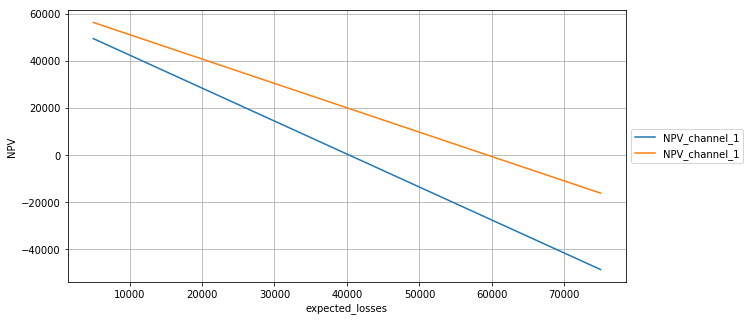

In [20]:
plt.figure(figsize=(10, 5))
plt.plot(expected_losses, NPV_channel_1, expected_losses, NPV_channel_2)
plt.xlabel("expected_losses")
plt.ylabel("NPV")
plt.grid(True)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5));
plt.show()

Для каждого канала выставляем различный максимальный уровень Expected losses, отсекая клиентов с отрицательным NPV.

### Как правильно рассчитать тариф для клиента

Рассмотрим значения NPV при фиксированных параметрах для различных expected_losses_12:

In [21]:
NPV_by_Exp_Losses = pd.Series(name='NPV_by_Exp_Losses')
NPV_by_Exp_Losses.index.name = 'num'

PV_by_Exp_Losses = pd.Series(name='PV_by_Exp_Losses')
PV_by_Exp_Losses.index.name = 'num'

for num in range(1, 16):
            PV, NPV=\
            NPV_short(
            prolongation_rate_1=0.8, 
            prolongation_rate_2=0.75, 
            manual_HGL_loss=0.2,
            tariff=60000, 
            discount_prolongation_1=0.95, 
            discount_prolongation_2=0.95,
            expected_losses_12=(expected_losses.loc[num]), 
            mean_HGL_loss=300000, 
            decrease_losses_2y=0.3, 
            decrease_losses_3y=0.6, 
            capital_requirement=0.2, 
            income_investment_rate=0.15,
            loss_adjustment=0.03, 
            opex=100, 
            tax_rate=0.2, 
            discount_rate=0.15,
            Acquisition_cost=10000
            )
            NPV_by_Exp_Losses.loc[num]=NPV
            PV_by_Exp_Losses.loc[num]=PV

pd.DataFrame([expected_losses, NPV_by_Exp_Losses, PV_by_Exp_Losses]).style.format('{:.0f}')

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
expected_losses,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000,70000,75000
NPV_by_Exp_Losses,28969,22370,15771,9172,2573,-4026,-10624,-17223,-23822,-30421,-37020,-43619,-50520,-58018,-65539
PV_by_Exp_Losses,38969,32370,25771,19172,12573,5974,-624,-7223,-13822,-20421,-27020,-33619,-40520,-48018,-55539


Для автомобиля с mean_HGL_loss=300000 и tariff=60000 с положительным NPV возможны только полисы при expected_losses<30000. 

Отметим, что при стоимости привлечения Acquisition_cost=5500 полисы с expected_losses=30000 тоже выгодны.

Для expected_losses>=30000 можем найти тариф. Найдем минимальный тариф, при котором NPV=0:

In [22]:
import scipy, scipy.optimize

def func(tariff):
            PV, NPV=NPV_short(
            prolongation_rate_1=0.8, 
            prolongation_rate_2=0.75, 
            manual_HGL_loss=0.2,
            tariff=tariff, 
            discount_prolongation_1=0.95, 
            discount_prolongation_2=0.95,
            expected_losses_12=expected_losses_12, 
            mean_HGL_loss=300000, 
            decrease_losses_2y=0.3, 
            decrease_losses_3y=0.6, 
            capital_requirement=0.2, 
            income_investment_rate=0.15,
            loss_adjustment=0.03, 
            opex=100, 
            tax_rate=0.2, 
            discount_rate=0.2,
            Acquisition_cost=10000
            )
            return (NPV - 0) ** 2

expected_losses_12=60000   #рассмотрим пример с убытком 60000 по типу "ущерб"
result = scipy.optimize.fmin(func, x0 = 100000, args=(), xtol=0.01, ftol=0.01, \
                                                        maxiter=None, maxfun=None, full_output=0, disp=1, \
                                                        retall=0, callback=None, initial_simplex=None)                             
print('Tariff for 0 NPV {}'.format(result))

Optimization terminated successfully.
         Current function value: 0.000007
         Iterations: 21
         Function evaluations: 42
Tariff for 0 NPV [111245.37467957]


С помощью функции scipy.optimize рассчитаем тарифы для всех expected_losses_12:

In [23]:
tariff_by_Exp_Losses = pd.Series(name='tariff_by_Exp_Losses')
tariff_by_Exp_Losses.index.name = 'num'
for num in range(1,16):
    expected_losses_12=expected_losses.loc[num]
    tariff_by_Exp_Losses.loc[num] = int(scipy.optimize.fmin(func, x0 = 120000, args=(), xtol=0.1, ftol=0.1, \
                                                        maxiter=None, maxfun=None, full_output=0, disp=1, \
                                                        retall=0, callback=None, initial_simplex=None))
pd.DataFrame([expected_losses, tariff_by_Exp_Losses]).style.format('{:.0f}')

Optimization terminated successfully.
         Current function value: 0.000118
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000015
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000010
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000103
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000295
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000585
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000973
         Iterations: 21
         Function evaluations: 42
Optimization terminated successful

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
expected_losses,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000,70000,75000
tariff_by_Exp_Losses,25875,33636,41397,49158,56918,64679,72440,80201,87962,95723,103484,111245,119006,126767,134528


### Какой тариф более выгодно предложить клиенту

Результаты тестирования тарифов для сравнимых клиентов показывают, что при снижении тарифа на 5% стоимость привлечения уменьшается на 30%, пролонгация увеличивается до 95%, риски снижаются на 15%.

In [24]:
NPV_discount = pd.Series(name='NPV_discount')
NPV_discount.index.name = 'num'

for num in range(1, 16):
            PV, NPV=\
            NPV_short(
            prolongation_rate_1=0.95,   #рост пролонгации до 95%
            prolongation_rate_2=0.9, 
            manual_HGL_loss=0.3*0.9,      #улучшение рисков
            tariff =(tariff_by_Exp_Losses.loc[num]*0.95),    #скидка
            discount_prolongation_1=0.95, 
            discount_prolongation_2=0.95,
            expected_losses_12=(expected_losses.loc[num])*0.85,   #улучшение рисков
            mean_HGL_loss=300000, 
            decrease_losses_2y=0.3, 
            decrease_losses_3y=0.6, 
            capital_requirement=0.2, 
            income_investment_rate=0.15,
            loss_adjustment=0.03, 
            opex=100, 
            tax_rate=0.2, 
            discount_rate=0.2,
            Acquisition_cost=(10000*0.7)     #снижение стоимтости привлечения на 30%
            )
            NPV_discount.loc[num]=NPV

pd.DataFrame([expected_losses, tariff_by_Exp_Losses, NPV_discount]).style.format('{:.0f}')

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
expected_losses,5000,10000,15000,20000,25000,30000,35000,40000,45000,50000,55000,60000,65000,70000,75000
tariff_by_Exp_Losses,25875,33636,41397,49158,56918,64679,72440,80201,87962,95723,103484,111245,119006,126767,134528
NPV_discount,897,1072,1246,1420,1594,1769,1943,2117,2292,2466,2641,2815,2990,3164,3339


Вывод: снижение  тарифов может увеличить NPV.

### К каким параметрам бОльшая чувствительность к оценке NPV?

Рассмотрим погрешность оценки NPV при разных погрешностях оценки expected_losses.

In [25]:
import random

NPV_by_error = pd.Series(name='NPV_by_error')
NPV_by_error.index.name = 'num'

expected_losses_error = pd.Series(name='expected_losses_error')
expected_losses_error.index.name = 'num'

tariff=50000
expected_losses_12=10000
for num in range (1, 300):
            expected_losses_error.loc[num]=random.normalvariate(expected_losses_12, 3000) # ошибка
            PV, NPV=\
            NPV_short(prolongation_rate_1=0.8, 
                     prolongation_rate_2=0.75, 
                     manual_HGL_loss=0.3,
                     tariff =tariff, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=(expected_losses_error.loc[num]), 
                     mean_HGL_loss=300000, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=100, 
                     tax_rate=0.2, 
                     discount_rate=0.2,
                     Acquisition_cost=10000
                     )
            NPV_by_error.loc[num]=NPV

df=pd.DataFrame([expected_losses_error, NPV_by_error]).style.format('{:.0f}')
df

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
expected_losses_error,12389,7955,8888,9470,8607,9349,7509,12317,10118,6769,16236,12569,13965,9666,17772,9513,11407,11056,9281,11402,8576,7627,10832,4639,9574,9517,9748,7212,16517,9214,10948,13549,12901,12310,6462,7536,15385,14950,9468,3211,14635,14728,6891,6793,12151,7955,10335,17167,12270,8891,9099,16479,9430,12390,2965,9256,13558,1821,7588,13423,5155,7061,13318,9308,10834,11878,6016,11474,14314,11784,7824,12952,12437,11796,10024,8529,11434,15271,7565,12415,14318,7664,8666,6105,14641,12935,9704,12502,6697,14620,11358,13644,8549,8775,6585,6223,2643,8915,11929,9933,7904,6830,12179,10136,11667,16678,10185,13382,10592,7043,10969,19195,11357,11287,12229,4928,10452,10374,6391,12391,12852,6904,7390,7148,4304,11295,14195,13814,6823,8810,5297,14371,11126,8878,3139,3801,13352,8588,7893,13922,7092,8083,12158,12611,6783,11724,14109,10741,13586,12978,13412,8507,5675,6329,10573,4441,11745,11057,8615,9093,11340,1303,11375,4359,14573,4472,12279,9626,8518,11439,14659,11310,8931,13479,6978,8300,9666,10487,6952,11262,8235,9726,10447,10849,8617,12720,4294,8092,11969,7002,5865,6355,12157,14505,5785,7482,9021,11382,10043,6546,14036,12398,9543,6993,13806,7577,11219,10776,9973,6587,8887,8933,9822,7632,13424,15528,16583,11496,10107,11198,11062,13005,12344,8949,13923,6338,13929,6228,10251,9370,4349,3804,11167,9317,9249,4504,2891,8067,14821,6496,9885,14163,7404,8529,7956,7872,11133,13719,10593,14333,5103,12270,14338,14499,8885,10695,12316,16098,8515,5558,7952,4112,15441,7964,1830,12138,8272,7263,13870,7345,12270,11996,13643,14154,2697,10929,15406,10260,14126,6296,9642,9898,11949,8923,10074,10074,9672,13654,4134,13812,9947,11513,8643,14069,7770,10535,12337,10011,13948
NPV_by_error,8939,14512,13340,12608,13693,12760,15073,9030,11793,16004,4103,8712,6958,12362,2173,12555,10173,10614,12845,10179,13731,14925,10896,18680,12477,12549,12259,15446,3750,12930,10750,7481,8295,9038,16389,15039,5173,5719,12611,20476,6116,5998,15850,15974,9238,14512,11521,2933,9089,13336,13075,3798,12658,8938,20784,12876,7469,22222,14974,7640,18032,15636,7771,12811,10893,9582,16950,10089,6519,9699,14678,8231,8879,9684,11912,13791,10140,5316,15003,8906,6514,14878,13619,16838,6108,8253,12314,8796,16094,6135,10235,7361,13765,13481,16234,16689,21189,13306,9517,12026,14576,15927,9203,11770,9846,3547,11709,7690,11198,15659,10723,384,10236,10324,9140,18317,11373,11471,16479,8936,8357,15833,15223,15527,19102,10314,6669,7148,15935,13437,17853,6447,10526,13353,20566,19733,7729,13717,14590,7012,15597,14351,9229,8660,15986,9774,6777,11011,7434,8199,7653,13819,17379,16556,11222,18929,9748,10613,13683,13082,10258,22874,10214,19033,6193,18891,9077,12412,13804,10133,6085,10295,13286,7569,15741,14078,12361,11330,15773,10356,14161,12286,11380,10875,13680,8523,19114,14341,9466,15710,17139,16523,9231,6279,17241,15107,13172,10205,11888,16283,6869,8928,12516,15721,7158,14988,10409,10966,11976,16232,13341,13283,12166,14918,7637,4994,3

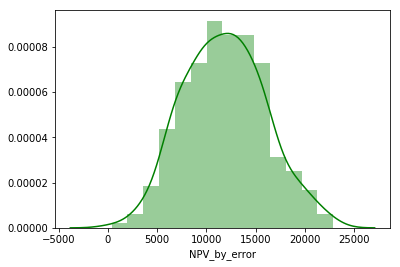

In [26]:
import seaborn as sns
from matplotlib.pyplot import show  # чтобы смотреть картинки без сохранения
sns.distplot(NPV_by_error, color="g")  # подготовим гистограмму и кривую распределения
show()  # покажем картинку

Добавим нормальное распределение, приближающее NPV_by_error:

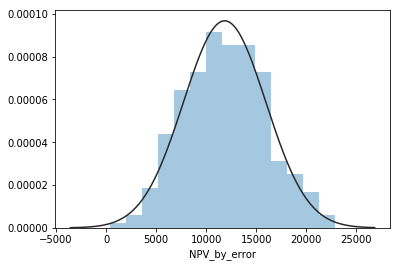

In [27]:
from scipy.stats import norm
ax = sns.distplot(NPV_by_error, fit=norm, kde=False)

При ошибке в expected_losses погрешность NPV составляет +/-6000.

Рассмотрим ошибку модели при колебаниях в оценке операционных расходов (opex).

In [28]:
import random

NPV_by_error_2 = pd.Series(name='NPV_by_error_2')
NPV_by_error_2.index.name = 'num'

opex_error = pd.Series(name='opex_error')
opex_error.index.name = 'num'

tariff=50000
expected_losses_12=10000
opex=100
for num in range (1, 300):
            opex_error.loc[num]=random.normalvariate(opex, 30)  # ошибка
            PV, NPV=\
            NPV_short(prolongation_rate_1=0.8, 
                     prolongation_rate_2=0.75, 
                     manual_HGL_loss=0.3,
                     tariff =tariff, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=expected_losses_12, 
                     mean_HGL_loss=300000, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=opex_error.loc[num], 
                     tax_rate=0.2, 
                     discount_rate=0.2,
                     Acquisition_cost=10000
                     )
            NPV_by_error_2.loc[num]=NPV

df_opex=pd.DataFrame([opex_error, NPV_by_error_2]).style.format('{:.0f}')
df_opex

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
opex_error,103,148,131,63,108,150,91,82,81,67,70,59,104,104,88,167,92,119,125,85,122,74,81,66,119,65,74,96,136,96,85,95,116,145,133,98,104,102,88,113,163,115,113,110,158,65,102,105,153,162,81,147,59,132,119,142,128,85,91,110,123,146,60,163,134,85,96,78,119,71,87,86,96,110,41,48,113,70,101,90,96,75,136,113,67,73,67,95,45,110,195,110,123,91,134,82,142,93,70,79,103,151,82,120,66,126,94,68,95,117,106,71,69,126,107,66,66,152,122,102,81,104,82,103,107,168,136,99,55,119,99,102,67,55,84,177,100,87,81,109,132,48,137,130,114,76,118,92,132,125,103,111,116,108,105,95,53,106,99,113,82,132,101,99,10,183,62,71,132,95,92,118,81,66,103,119,60,101,117,47,116,111,103,175,119,150,87,65,101,139,73,70,149,135,176,69,163,118,131,93,113,93,89,103,115,68,170,107,142,87,66,108,54,95,95,142,108,106,146,91,110,89,62,115,110,69,77,84,75,112,73,93,73,90,125,128,131,94,145,108,109,80,56,96,74,124,78,148,109,99,62,74,99,77,107,89,143,99,115,175,37,139,2,124,71,89,124,87,76,66,95,112,97,124,99,89,88,150,89,134,59,106,138,111,94,109,80,105,88,90,137,162,63,95,164,149,133,67,88
NPV_by_error_2,11894,11029,11352,12644,11799,10992,12109,12283,12311,12568,12518,12724,11857,11869,12171,10673,12092,11575,11467,12236,11521,12439,12297,12585,11586,12611,12445,12022,11256,12016,12219,12038,11630,11084,11318,11984,11860,11904,12175,11704,10744,11658,11688,11759,10840,12605,11911,11855,10933,10769,12312,11050,12723,11328,11578,11134,11416,12232,12112,11750,11506,11065,12700,10752,11297,12226,12023,12353,11576,12502,12192,12207,12014,11760,13061,12923,11703,12512,11919,12125,12027,12411,11264,11687,12571,12447,12575,12040,12993,11749,10131,11755,11497,12118,11301,12291,11146,12083,12518,12339,11885,10968,12291,11559,12584,11441,12047,12552,12035,11619,11827,12489,12530,11446,11805,12595,12593,10955,11523,11912,12297,11871,12290,11889,11816,10641,11261,11968,12805,11586,11954,11894,12563,12789,12250,10475,11948,12188,12295,11771,11339,12932,11229,11374,11669,12395,11608,12103,11342,11460,11891,11727,11634,11784,11843,12045,12845,11831,11968,11693,12291,11340,11924,11958,13662,10365,12672,12489,11327,12033,12096,11591,12297,12580,11892,11576,12704,11925,11610,12943,11643,11738,11888,10516,11588,10981,12195,12611,11931,11201,12465,12506,11005,11269,10500,12523,10742,11603,11345,12066,11701,12073,12145,11879,11656,12553,10617,11813,11140,12197,12586,11783,12819,12040,12028,11135,11792,11824,11065,12114,11757,12147,12662,11659,11754,12525,12378,12237,12413,11714,12462,12080,12451,12124,11472,11411,11352,12060,11089,11781,11765,12322,12779,12025,12436,11480,12352,11020,11773,11968,12668,12436,11956,12382,11812,12144,11126,11963,11659,10508,13137,11199,13805,11484,12490,12155,11487,12186,12392,12585,12033,11718,11998,11477,11954,12146,12162,10999,12147,11288,12717,11826,11217,11739,12053,11779,12314,11855,12169,12128,11239,10768,12646,12030,10717,11002,11305,12568,12179


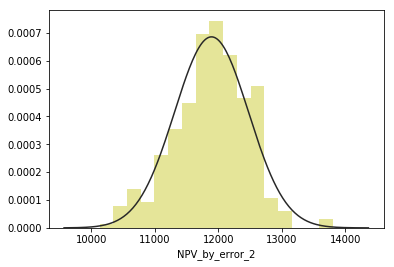

In [29]:
from scipy.stats import norm
ax = sns.distplot(NPV_by_error_2, fit=norm, kde=False, color="y")

При большой погрешности в расчетах opex оценка NPV меняется +/-1000.

Manual_HGL_loss - параметр внутри модели, который меняет кривую HGL_loss_rate.

С помощью этого параметра смоделируем ошибку в кривой и оценим итоговую погршеность в расчете NPV.

In [30]:
NPV_by_error_3 = pd.Series(name='NPV_by_error_3')
NPV_by_error_3.index.name = 'num'

manual_HGL_loss_error = pd.Series(name='manual_HGL_loss_error')
manual_HGL_loss_error.index.name = 'num'

tariff=50000
expected_losses_12=10000
manual_HGL_loss=0.3
for num in range (1, 300):
            manual_HGL_loss_error.loc[num]=random.normalvariate(manual_HGL_loss, 0.1)  # ошибка
            PV, NPV=\
            NPV_short(prolongation_rate_1=0.8, 
                     prolongation_rate_2=0.75, 
                     manual_HGL_loss=manual_HGL_loss_error.loc[num],
                     tariff =tariff, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=expected_losses_12, 
                     mean_HGL_loss=300000, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=100, 
                     tax_rate=0.2, 
                     discount_rate=0.2,
                     Acquisition_cost=10000
                     )
            NPV_by_error_3.loc[num]=NPV

df_manual_HGL_loss=pd.DataFrame([manual_HGL_loss_error, NPV_by_error_3]).style.format('{:.2f}')
df_manual_HGL_loss

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
manual_HGL_loss_error,0.33,0.30,0.31,0.28,0.05,0.22,0.45,0.48,0.42,0.45,0.08,0.38,0.48,0.23,0.26,0.22,0.33,0.37,0.33,0.27,0.36,0.46,0.20,0.34,0.20,0.30,0.41,0.31,0.27,0.26,0.40,0.25,0.28,0.10,0.14,0.37,0.36,0.14,0.18,0.31,0.20,0.14,0.32,0.36,0.23,0.31,0.25,0.43,0.20,0.34,0.21,0.54,0.44,0.45,0.33,0.29,0.38,0.42,0.29,0.42,0.33,0.39,0.36,0.25,0.36,0.46,0.21,0.33,0.19,0.31,0.19,0.43,0.22,0.19,0.48,0.31,0.26,0.28,0.22,0.30,0.33,0.26,0.17,0.31,0.35,0.47,0.18,0.26,0.27,0.46,0.14,0.37,0.35,0.32,0.30,0.35,0.14,0.34,0.15,0.50,0.28,0.32,0.47,0.17,0.33,0.26,0.28,0.26,0.20,0.17,0.42,0.18,0.19,0.20,0.34,0.32,0.30,0.29,0.41,0.31,0.24,0.23,0.36,0.37,0.38,0.26,0.26,0.25,0.24,0.56,0.26,0.27,0.31,0.24,0.41,0.48,0.18,0.34,0.25,0.23,0.37,0.31,0.39,0.23,0.23,0.28,0.23,0.23,0.33,0.35,0.43,0.38,0.21,0.20,0.29,0.21,0.18,0.29,0.16,0.34,0.24,0.28,0.50,0.37,0.26,0.31,0.36,0.19,0.21,0.29,0.28,0.32,0.18,0.26,0.42,0.44,0.38,0.32,0.34,0.52,0.18,0.29,0.38,0.36,0.29,0.17,0.09,0.24,0.22,0.39,0.26,0.25,0.23,0.24,0.31,0.37,0.39,0.31,0.29,0.23,0.28,0.26,0.27,0.13,0.36,0.23,0.31,0.25,0.14,0.41,0.14,0.44,0.29,0.55,0.20,0.39,0.34,0.40,0.36,0.23,0.15,0.45,0.30,0.31,0.36,0.31,0.36,0.23,0.50,0.32,0.32,0.19,0.43,0.26,0.26,0.34,0.29,0.25,0.58,0.15,0.32,0.44,0.20,0.41,0.40,0.33,0.37,0.27,0.35,0.22,0.59,0.55,0.24,0.42,0.47,0.27,0.21,0.18,0.28,0.45,0.39,0.27,0.31,0.37,0.30,0.48,0.31,0.31,0.27,0.48,0.36,0.26,0.25,0.35,0.41,0.29,0.31,0.17,0.41,0.27,0.56,0.36,0.23,0.42,0.21,0.15,0.45,0.38,0.28,0.07,0.22,0.33,0.33,0.34,0.42,0.25,0.22,0.27,0.36
NPV_by_error_3,11582.86,11965.51,11755.22,12162.80,15382.05,13009.76,9869.30,9496.18,10278.95,9906.75,14862.10,10891.60,9496.24,12850.03,12449.84,12973.45,11545.81,11026.69,11554.65,12374.96,11081.30,9839.26,13298.81,11393.70,13246.49,11897.89,10413.54,11865.62,12293.19,12481.49,10642.80,12623.44,12179.59,14697.96,14071.47,10990.79,11146.37,14118.14,13618.37,11759.66,13268.32,14128.29,11704.29,11078.63,12882.18,11822.66,12675.80,10212.30,13298.25,11342.08,13124.89,8677.37,10098.19,9995.00,11580.67,12021.97,10855.92,10396.43,12021.40,10359.97,11565.17,10797.53,11148.80,12657.74,11180.23,9820.74,13130.86,11528.34,13414.39,11866.86,13477.46,10146.02,12965.93,13377.20,9588.11,11769.05,12519.83,12254.80,13036.76,11876.51,11534.40,12499.70,13750.15,11851.56,11269.13,9713.24,13591.06,12422.75,12399.78,9832.87,14104.15,10985.41,11279.41,11612.44,11878.60,11306.11,14083.84,11398.98,13954.42,9282.96,12255.18,11635.06,9675.35,13641.92,11475.54,12475.84,12146.57,12473.70,13271.06,13745.33,10374.95,13586.24,13389.20,13338.59,11396.42,11621.34,11881.37,12051.86,10437.35,11862.40,12695.81,12826.96,11147.37,10964.83,10810.81,12465.86,12466.17,12636.98,12699.76,8420.17,12490.40,12378.06,11758.56,12801.27,10496.51,9576.37,13569.91,11355.03,12643.39,12862.48,11039.01,11845.71,10676.21,12927.55,12902.37,12167.37,12898.53,12821.82,11543.39,11317.06,10144.76,10840.16,13179.18,13358.62,12022

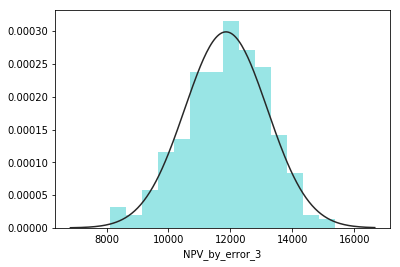

In [31]:
ax = sns.distplot(NPV_by_error_3, fit=norm, kde=False, color="c")

### Оценим общую погрешность модели методом Монте-Карло

Итоговую погрешность модели при ошибке нескольких параметров оценим методом Монте-Карло.

In [32]:
NPV_by_error_4 = pd.Series(name='NPV_by_error_4')
NPV_by_error_4.index.name = 'num'

expected_losses_error = pd.Series(name='expected_losses_error')
expected_losses_error.index.name = 'num'

manual_HGL_loss_error = pd.Series(name='manual_HGL_loss_error')
manual_HGL_loss_error.index.name = 'num'

opex_error = pd.Series(name='opex_error')
opex_error.index.name = 'num'

tariff=50000
expected_losses_12=10000
manual_HGL_loss=0.3
opex=100

for num in range (1, 500):
            manual_HGL_loss_error.loc[num]=random.normalvariate(manual_HGL_loss, 0.1)  # ошибка
            opex_error.loc[num]=random.normalvariate(opex, 30)   # ошибка
            expected_losses_error.loc[num]=random.normalvariate(expected_losses_12, 3000)  # ошибка
            
            PV, NPV=\
            NPV_short(prolongation_rate_1=0.8, 
                     prolongation_rate_2=0.75, 
                     manual_HGL_loss=manual_HGL_loss_error.loc[num],
                     tariff = tariff, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=expected_losses_error.loc[num], 
                     mean_HGL_loss=300000, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=opex_error.loc[num], 
                     tax_rate=0.2, 
                     discount_rate=0.2,
                     Acquisition_cost=10000
                     )
            NPV_by_error_4.loc[num]=NPV

df_error=pd.DataFrame([manual_HGL_loss_error, opex_error, \
                       expected_losses_error, NPV_by_error_4]).style.format('{:.2f}')
df_error

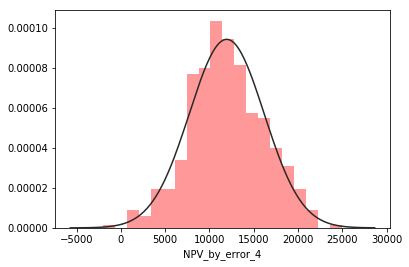

In [33]:
ax = sns.distplot(NPV_by_error_4, fit=norm, kde=False, color="r")

Для рассмотренного сегмента клиентов при возможных ошибках модели NPV с маленькой вероятностью будет ниже нуля.

Рассмотрим другой сегмент, с более высокими прогнозируемыми потерями:

In [34]:
NPV_by_error_5 = pd.Series(name='NPV_by_error_5')
NPV_by_error_5.index.name = 'num'

expected_losses_error = pd.Series(name='expected_losses_error')
expected_losses_error.index.name = 'num'

manual_HGL_loss_error = pd.Series(name='manual_HGL_loss_error')
manual_HGL_loss_error.index.name = 'num'

opex_error = pd.Series(name='opex_error')
opex_error.index.name = 'num'

tariff=50000
expected_losses_12=10000
manual_HGL_loss=1
opex=100
mean_HGL_loss=400000

for num in range (1, 500):
            manual_HGL_loss_error.loc[num]=random.normalvariate(manual_HGL_loss, 0.05)  # ошибка
            opex_error.loc[num]=random.normalvariate(opex, 50)   # ошибка
            expected_losses_error.loc[num]=random.normalvariate(expected_losses_12, 2000)  # ошибка
            
            PV, NPV=\
            NPV_short(prolongation_rate_1=0.9, 
                     prolongation_rate_2=0.8, 
                     manual_HGL_loss=manual_HGL_loss_error.loc[num],
                     tariff = tariff, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=expected_losses_error.loc[num], 
                     mean_HGL_loss=mean_HGL_loss, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=opex_error.loc[num], 
                     tax_rate=0.2, 
                     discount_rate=0.15,
                     Acquisition_cost=6000
                     )
            NPV_by_error_5.loc[num]=NPV

df_error=pd.DataFrame([manual_HGL_loss_error, opex_error, \
                       expected_losses_error, NPV_by_error_5]).style.format('{:.2f}')
df_error

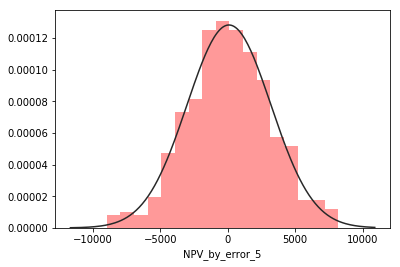

In [35]:
ax = sns.distplot(NPV_by_error_5, fit=norm, kde=False, color="r")

Если для сегмента клиентов NPV с большой вероятностью будет ниже 0, стратегию одобрения нужно настраивать с учетом рассчитанной ошибки (например, брать полисы с NPV>=5000).

### Поговорим еще немного о ставке дисконтирования

In [36]:
PV, NPV=NPV_short(prolongation_rate_1=0.6, 
                     prolongation_rate_2=0.3, 
                     manual_HGL_loss=0.5,
                     tariff = 50000, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=20000, 
                     mean_HGL_loss=300000, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.08, 
                     opex=100, 
                     tax_rate=0.2, 
                     discount_rate=0.3,
                     Acquisition_cost=10000
                  )
NPV

-276.0039226564695

# Домашнее задание

*  Найти ошибку NPV, смоделировав ошибки mean_HGL_loss и income_investment_rate
*  На основании рассчитанной ошибки составить тарифную сетку для пары (expected_losses_12, mean_HGL_loss)

In [38]:
# Моделируем ошибку mean_HGL_loss
import random

NPV_by_error_10 = pd.Series(name='NPV_by_error_10')
NPV_by_error_10.index.name = 'num'

mean_HGL_loss_error = pd.Series(name='mean_HGL_loss_error')
mean_HGL_loss_error.index.name = 'num'

mean_HGL_loss = 300000

tariff=50000

for num in range (1, 300):
            mean_HGL_loss_error.loc[num]=random.normalvariate(mean_HGL_loss, 100000) # ошибка
            PV, NPV=\
            NPV_short(prolongation_rate_1=0.8, 
                     prolongation_rate_2=0.75, 
                     manual_HGL_loss=0.3,
                     tariff =tariff, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=10000, 
                     mean_HGL_loss=mean_HGL_loss_error.loc[num], 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=100, 
                     tax_rate=0.2, 
                     discount_rate=0.2,
                     Acquisition_cost=10000
                     )
            NPV_by_error_10.loc[num]=NPV

df=pd.DataFrame([mean_HGL_loss_error, NPV_by_error_10]).style.format('{:.0f}')
df

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
mean_HGL_loss_error,140436,244350,215881,117533,152258,243729,230259,251330,491468,286305,294142,200177,274165,439539,300448,227176,330162,371763,171271,185818,394816,121978,297015,342990,429288,156524,226428,353664,301482,413714,214065,361418,182591,267835,423956,307261,483697,334074,154398,284050,103765,146039,322374,283229,394442,294581,215004,339851,113094,560213,429739,432658,215306,368750,426901,225908,188045,482822,406955,239987,280473,274063,223495,69471,328528,377418,388993,93391,245354,364336,291238,283842,378053,358969,136129,414454,427464,218960,377423,273373,364398,187712,254853,487085,184421,458508,157876,515456,337807,401865,570111,316718,288087,149003,481160,376244,293499,376589,286872,239280,407349,428211,90990,463702,166596,218557,425043,266536,374820,377476,582470,149880,331029,175972,291850,261758,314099,263871,295866,290458,384474,349743,318886,172666,132049,435063,208003,209362,590437,232380,189436,225480,459004,330343,210761,182555,193276,9571,137640,201435,348395,271007,374574,102050,261732,425872,358481,296548,303440,418597,345878,285034,301426,319307,363734,422701,271325,150922,401652,326530,474893,275316,359242,417863,219403,336501,394949,181713,215612,256684,222095,136587,335611,179552,286027,295433,322322,322490,214527,330652,396100,313722,305713,287506,376756,201392,201414,343066,276349,250491,336488,374587,134874,128558,294765,181921,429944,394468,516127,390133,270384,348677,358284,408859,294037,474777,628341,299645,226419,120092,507322,317089,109742,426697,273833,379784,553004,241259,214077,232965,365830,326930,257303,320033,312675,538424,352527,238734,447419,172902,226740,283600,270298,220174,263473,360973,356172,146280,383348,257909,128451,337842,337309,290410,336326,370163,278606,201741,396393,293257,276719,520243,93136,345220,188115,539585,391415,283867,211505,282668,309427,243246,293144,203127,269262,333651,449090,110890,219032,316918,285606,267396,222324,131680,463303,447177,405858,341980,361485,321046,223809,450028,209762,280077,187045,302460,224189,321263,245795,79016,294833,392781,220458,447458,378482,386632,340558,361820,367723
NPV_by_error_10,14173,12720,13118,14493,14007,12729,12917,12622,9265,12133,12024,13337,12303,9991,11936,12960,11520,10938,13742,13538,10616,14431,11984,11341,10134,13948,12970,11192,11921,10352,13143,11083,13583,12392,10209,11840,9373,11465,13978,12165,14685,14094,11629,12176,10621,12018,13130,11385,14555,8304,10128,10087,13126,10981,10168,12978,13507,9386,10446,12781,12215,12304,13011,15165,11543,10859,10698,14830,12706,11042,12064,12168,10851,11117,14233,10342,10160,13075,10859,12314,11041,13512,12573,9326,13558,9726,13929,8929,11413,10518,8165,11708,12108,14053,9409,10876,12033,10871,12125,12791,10441,10149,14864,9653,13807,13080,10194,12410,10896,10859,7993,14041,11508,13676,12056,12477,11745,12447,12000,12075,10761,11246,11678,13722,14290,10053,13228,13209,7881,12887,13488,12984,9719,11

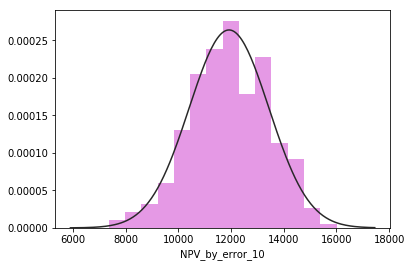

In [39]:
ax = sns.distplot(NPV_by_error_10, fit=norm, kde=False, color="m")
# Погрешность оценки NPV составила +/- 2,500

In [41]:
# Моделируем ошибку income_investment_rate
import random

NPV_by_error_11 = pd.Series(name='NPV_by_error_11')
NPV_by_error_11.index.name = 'num'

income_investment_rate_error = pd.Series(name='income_investment_rate_error')
income_investment_rate_error.index.name = 'num'

income_investment_rate=0.15

tariff=50000

for num in range (1, 300):
            income_investment_rate_error.loc[num]=random.normalvariate(income_investment_rate, 0.05) # ошибка
            PV, NPV=\
            NPV_short(prolongation_rate_1=0.8, 
                     prolongation_rate_2=0.75, 
                     manual_HGL_loss=0.3,
                     tariff =tariff, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=10000, 
                     mean_HGL_loss=300000, 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=income_investment_rate_error.loc[num],
                     loss_adjustment=0.03, 
                     opex=100, 
                     tax_rate=0.2, 
                     discount_rate=0.2,
                     Acquisition_cost=10000
                     )
            NPV_by_error_11.loc[num]=NPV

df = pd.DataFrame([income_investment_rate_error, NPV_by_error_11]).style.format('{:.2f}')
df

num,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,279,280,281,282,283,284,285,286,287,288,289,290,291,292,293,294,295,296,297,298,299
income_investment_rate_error,0.19,0.16,0.15,0.13,0.15,0.10,0.18,0.16,0.21,0.16,0.12,0.05,0.18,0.12,0.12,0.21,0.10,0.19,0.15,0.22,0.21,0.10,0.18,0.17,0.22,0.10,0.11,0.13,0.13,0.15,0.19,0.21,0.10,0.20,0.12,0.20,0.18,0.23,0.16,0.14,0.17,0.16,0.07,0.13,0.18,0.18,0.19,0.05,0.21,0.17,0.19,0.13,0.16,0.22,0.08,0.15,0.15,0.11,0.20,0.16,0.06,0.13,0.23,0.13,0.16,0.19,0.16,0.12,0.07,0.17,0.18,0.16,0.19,0.19,0.17,0.13,0.08,0.17,0.11,0.19,0.22,0.19,0.14,0.23,0.07,0.15,0.13,0.13,0.17,0.11,0.19,0.22,0.17,0.23,0.19,0.15,0.17,0.19,0.20,0.16,0.17,0.15,0.21,0.15,0.12,0.15,0.16,0.21,0.15,0.18,0.03,0.12,0.08,0.20,0.13,0.12,0.28,0.22,0.20,0.11,0.10,0.16,0.10,0.11,0.21,0.16,0.15,0.19,0.15,0.22,0.20,0.08,0.11,0.12,0.17,0.08,0.18,0.06,0.12,0.14,0.15,0.23,0.17,0.12,0.13,0.12,0.17,0.20,0.23,0.20,0.13,0.15,0.08,0.16,0.26,0.12,0.21,0.22,0.05,0.23,0.12,0.13,0.09,0.07,0.10,0.15,0.14,0.24,0.16,0.11,0.11,0.17,0.17,0.14,0.13,0.08,0.10,0.06,0.16,0.12,0.13,0.18,0.14,0.20,0.09,0.13,0.20,0.21,0.11,0.14,0.07,0.15,0.20,0.16,0.13,0.13,0.08,0.09,0.08,0.19,0.12,0.12,0.18,0.13,0.12,0.19,0.08,0.15,0.21,0.11,0.23,0.18,0.20,0.18,0.14,0.14,0.17,0.11,0.06,0.23,0.18,0.25,0.13,0.16,0.09,0.12,0.16,0.20,0.14,0.10,0.24,0.16,0.16,0.14,0.15,0.14,0.06,0.14,0.12,0.04,0.18,0.14,0.08,0.17,0.19,0.15,0.18,0.13,0.18,0.14,0.20,0.18,0.19,0.14,0.16,0.08,0.13,0.07,0.18,0.27,0.02,0.13,0.06,0.21,0.06,0.05,0.17,0.20,0.14,0.11,0.20,0.17,0.15,0.14,0.08,0.09,0.14,0.05,0.11,0.21,0.27,0.11,0.13,0.15,0.15,0.15,0.15,0.14,0.12,0.19,0.18,0.16,0.17,0.17,0.16,0.13,0.19,0.11,0.18
NPV_by_error_11,12974.90,12145.26,11924.96,11304.53,11886.37,10508.71,12820.16,12262.96,13542.91,12131.68,11220.51,9387.83,12696.70,11229.98,11148.44,13635.08,10764.10,12935.03,12000.55,13718.60,13556.42,10668.66,12718.81,12448.99,13803.79,10724.19,11000.38,11539.50,11426.49,11889.83,13018.20,13534.53,10672.39,13203.96,11115.96,13360.42,12649.58,14133.18,12121.47,11685.46,12390.69,12122.83,9820.60,11371.56,12775.03,12628.68,13034.28,9402.39,13640.43,12551.29,13095.96,11307.88,12161.20,13652.18,10175.09,11864.55,12010.89,10848.60,13211.75,12104.60,9594.52,11473.25,13931.53,11405.91,12220.52,12872.81,12255.60,11266.05,9838.24,12476.04,12668.07,12268.49,12882.75,13053.79,12479.75,11298.40,10139.51,12364.62,10864.12,13043.86,13859.81,12947.60,11635.29,13914.27,9762.31,12012.48,11323.37,11443.78,12485.79,10877.12,13022.92,13734.45,12436.98,13944.65,12929.58,12070.07,12566.86,12940.26,13290.27,12166.38,12480.26,11872.07,13408.92,11895.60,11164.15,11919.57,12319.13,13568.66,12037.54,12661.87,8682.11,11106.96,9986.46,13220.83,11506.42,11120.53,15405.78,13878.25,13195.02,10779.95,10662.50,12095.25,10744.75,10994.22,13410.57,12209.28,12035.00,13066.23,11944.97,13769.40,13327.22,10034.43,10944.84,11066.97,12397.17,10151.95,12747.72,9640.60,11227.27,11679.75,12046.86,14086.25,12389.50,11082.87,11372.48,11259.34,12531.44,13195.18,13916.47,13298.08,11516.22,11871.12,10218.88,

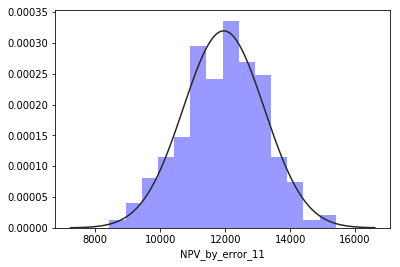

In [42]:
ax = sns.distplot(NPV_by_error_11, fit=norm, kde=False, color="b")
# Погрешность ошибки NPV составила ~ +/-2000

In [89]:
#тарифы без учета ошибки
import scipy, scipy.optimize

def func1(tariff):
            PV, NPV=NPV_short(
            prolongation_rate_1=0.8, 
            prolongation_rate_2=0.75, 
            manual_HGL_loss=0.2,
            tariff=tariff, 
            discount_prolongation_1=0.95, 
            discount_prolongation_2=0.95,
            expected_losses_12=expected_losses_12, 
            mean_HGL_loss=mean_HGL_loss, 
            decrease_losses_2y=0.3, 
            decrease_losses_3y=0.6, 
            capital_requirement=0.2, 
            income_investment_rate=0.15,
            loss_adjustment=0.03, 
            opex=100, 
            tax_rate=0.2, 
            discount_rate=0.2,
            Acquisition_cost=10000
            )
            return (NPV - 0) ** 2
# Выбираем сегменты (для быстроты вычислений взял только по 4 значения)
col = np.arange(10000, 60000, 15000) # колонки - expected_loss_12
row = np.arange(200000, 1000000, 200000) # строки - mean_HGL_loss
tariffs = pd.DataFrame(index = row, columns = col);

for expected_losses_12 in col:
    for mean_HGL_loss in row:
         tariffs.loc[mean_HGL_loss, expected_losses_12] = int(scipy.optimize.fmin(func1, x0 = 120000, args=(), xtol=0.1, ftol=0.1, \
                                                        maxiter=None, maxfun=None, full_output=0, disp=1, \
                                                        retall=0, callback=None, initial_simplex=None))


Optimization terminated successfully.
         Current function value: 0.000265
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000073
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.001113
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000262
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000023
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000875
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000399
         Iterations: 22
         Function evaluations: 44
Optimization terminated successful

In [94]:

print('Tarrifs without corrections:')
print('\trows - mean_HGL_loss')
print('\tcolumns - expected_loss_12:')

tariffs

Tarrifs without corrections:
	rows - mean_HGL_loss
	columns - expected_loss_12:


,10000,25000,40000,55000
200000,32484,55767,79050,102333
400000,34787,58070,81352,104635
600000,37090,60372,83655,106938
800000,39392,62675,85958,109240


In [96]:
# моделирование совместной ошибки mean_HGL_loss и expected_losses_12
# и нахождение корректировки к NPV для разных ценовых сегментов
from scipy.stats import norm

correсtions = pd.DataFrame(index = row, columns = col );

NPV_by_error_13 = pd.Series(name='NPV_by_error_13')
NPV_by_error_13.index.name = 'num'

expected_losses_error = pd.Series(name='expected_losses_error')
expected_losses_error.index.name = 'num'

mean_HGL_loss_error = pd.Series(name='mean_HGL_loss_error')
mean_HGL_loss_error.index.name = 'num'

for expected_losses_12 in col:
    for mean_HGL_loss in row:
        tariff= tariffs.loc[mean_HGL_loss, expected_losses_12]

        for num in range (1, 50):
            mean_HGL_loss_error.loc[num]=random.normalvariate(mean_HGL_loss, 0.2*mean_HGL_loss)   # ошибка
            expected_losses_error.loc[num]=random.normalvariate(expected_losses_12, 0.2*expected_losses_12)  # ошибка

            PV, NPV=\
            NPV_short(prolongation_rate_1=0.9, 
                     prolongation_rate_2=0.8, 
                     manual_HGL_loss=1,
                     tariff = tariff, 
                     discount_prolongation_1=0.95, 
                     discount_prolongation_2=0.95,
                     expected_losses_12=expected_losses_error.loc[num], 
                     mean_HGL_loss=mean_HGL_loss_error.loc[num], 
                     decrease_losses_2y=0.3, 
                     decrease_losses_3y=0.6, 
                     capital_requirement=0.2, 
                     income_investment_rate=0.15,
                     loss_adjustment=0.03, 
                     opex=100, 
                     tax_rate=0.2, 
                     discount_rate=0.15,
                     Acquisition_cost=6000
                     )
            NPV_by_error_13.loc[num]=NPV
            percentile_5 = np.percentile(NPV_by_error_13, 5) # хотим, чтобы 5%квантиль оказалась равно 0 или больше
            correсtions.loc[mean_HGL_loss, expected_losses_12] = 0 if percentile_5 >= 0 else -percentile_5

In [100]:
print('Corrections:')
print('\trows - mean_HGL_loss')
print('\tcolumns - expected_loss_12:')

correсtions

Corrections:
	rows - mean_HGL_loss
	columns - expected_loss_12:


,10000,25000,40000,55000
200000,9445.34,14585.5,21630.9,21990.1
400000,23043,28232.6,31257,40393.7
600000,32340,31764.9,38471.8,49383.8
800000,43604,52897.5,47832.7,55861.4


In [101]:
import scipy, scipy.optimize

def func2(tariff):
            PV, NPV=NPV_short(
            prolongation_rate_1=0.8, 
            prolongation_rate_2=0.75, 
            manual_HGL_loss=0.2,
            tariff=tariff, 
            discount_prolongation_1=0.95, 
            discount_prolongation_2=0.95,
            expected_losses_12=expected_losses_12, 
            mean_HGL_loss=mean_HGL_loss, 
            decrease_losses_2y=0.3, 
            decrease_losses_3y=0.6, 
            capital_requirement=0.2, 
            income_investment_rate=0.15,
            loss_adjustment=0.03, 
            opex=100, 
            tax_rate=0.2, 
            discount_rate=0.2,
            Acquisition_cost=10000
            )
            return (NPV - correction) ** 2

tariffs_with_corrections = pd.DataFrame(index = row, columns = col );

for expected_losses_12 in col:
    for mean_HGL_loss in row:
        correction = correсtions.loc[mean_HGL_loss, expected_losses_12]
        tariffs_with_corrections.loc[mean_HGL_loss, expected_losses_12] = int(scipy.optimize.fmin(func2, x0 = 120000, args=(), xtol=0.1, ftol=0.1, \
                                                        maxiter=None, maxfun=None, full_output=0, disp=1, \
                                                        retall=0, callback=None, initial_simplex=None))

Optimization terminated successfully.
         Current function value: 0.000088
         Iterations: 23
         Function evaluations: 46
Optimization terminated successfully.
         Current function value: 0.000139
         Iterations: 22
         Function evaluations: 44
Optimization terminated successfully.
         Current function value: 0.000991
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000388
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000026
         Iterations: 21
         Function evaluations: 42
Optimization terminated successfully.
         Current function value: 0.000063
         Iterations: 20
         Function evaluations: 40
Optimization terminated successfully.
         Current function value: 0.000055
         Iterations: 20
         Function evaluations: 40
Optimization terminated successful

In [103]:
print('Corrected tariffs:')
print('\trows - mean_HGL_loss')
print('\tcolumns - expected_loss_12:')

tariffs_with_corrections

Corrected tariffs:
	rows - mean_HGL_loss
	columns - expected_loss_12:


,10000,25000,40000,55000
200000,44111,73721,105677,129402
400000,63152,92823,119828,154358
600000,76899,99473,131012,167727
800000,93067,127789,144838,178003
